In [159]:
import matplotlib.pyplot as plt
import numpy as np

# compare_pmem_vs_oracle_gmm.py
import jax
import jax.numpy as jnp
from jax import random
import numpy as np

# diffusionlab imports (adjust imports if your environment differs)
from diffusionlab.dynamics import VariancePreservingProcess
from diffusionlab.losses import DiffusionLoss
from diffusionlab.vector_fields import VectorFieldType

# repo imports
from src.diffusion_mem_gen.models.gmm import (
    IsoHomGMMInitStrategy,
    iso_hom_gmm_create_initialization_parameters,
    IsoHomGMMSharedParametersEstimator,
)
from src.diffusion_mem_gen.utils.factories import compute_loss_factory

key = random.PRNGKey(0)


## Labratory Settings

Here we set d, M, N, K 

In [168]:

# Dimension and training samples.
laboratory_d = 30 # data dimension
laboratory_N = 200 # number of training samples, must be pollynomial in d
laboratory_M = 200 # The capacity of the models, we investiage for less M < N
laboratory_K = 12 # number of components in the GMM

#u_means_mean = 20 # order d
u_means_variance = 30 ** (1/2) # order 1, controls the variance of the means of the true distributon 
sample_variance = 1  # isotropic variance for each component

# Ground-truth GMM params (you can replace these with your exact true mixture)
key, sk = random.split(key)
true_means = random.normal(sk, (laboratory_K, laboratory_d)) * u_means_variance
equal_weighted_prior = jnp.array([1/laboratory_K for _ in range(laboratory_K)])  # must sum to 1

# Sample training set from the true GMM
key, sk = random.split(key)
comp_ids = random.choice(sk, laboratory_K, shape=(laboratory_N,), p=equal_weighted_prior)
key, sk = random.split(key)
X_train = true_means[comp_ids] + jnp.sqrt(sample_variance) * random.normal(sk, (laboratory_N, laboratory_d))


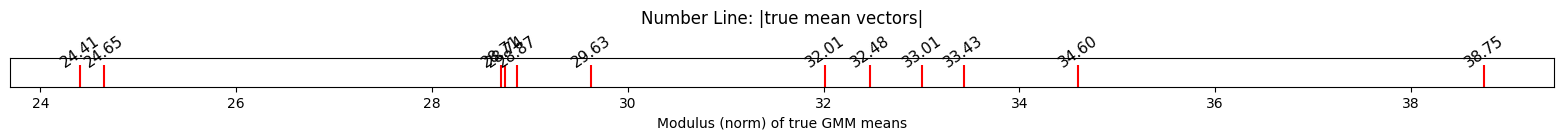

In [169]:
# Plot a number line with the modulus (Euclidean norm) of the true means
import matplotlib.pyplot as plt

true_means_modulus = jnp.linalg.norm(true_means, axis=1)
plt.figure(figsize=(16, 2))  # make the plot much wider and a little taller
plt.scatter(true_means_modulus, jnp.zeros_like(true_means_modulus), color='red', marker='|', s=320)
for i, x in enumerate(true_means_modulus):
    plt.text(float(x), 0.08, f"{x:.2f}", ha='center', va='bottom', fontsize=11, rotation=35)
plt.yticks([])
plt.xlabel('Modulus (norm) of true GMM means')
plt.title('Number Line: |true mean vectors|', pad=25)
plt.tight_layout(pad=2)
plt.ylim(-0.1, 0.2)
plt.show()

In [170]:
# Diffusion process
diffusion_process = VariancePreservingProcess()

# Loss object: replace with your custom loss instance if you have one
loss_obj = DiffusionLoss(diffusion_process, vector_field_type=VectorFieldType.X0, num_noise_draws_per_sample=100)

# Time grid for evaluation
times = jnp.linspace(0.01, 0.99, 26)
# -------------------------------------------------------------

def evaluate_model_losses(key, model_callable, X_data, loss_obj, times):
    losses = []
    for t_val in times:
        compute_loss = compute_loss_factory(loss_obj, jnp.array(t_val))
        key, subk = random.split(key)
        loss_val = compute_loss(subk, model_callable, X_data)
        losses.append(loss_val)

    return jnp.stack(losses)


def calculate_L_N_t(key, model_callable, X_data, loss_obj, times):
    loss_per_t = []
    for t_val in times:
        compute_loss = compute_loss_factory(loss_obj, jnp.array(t_val))
        key, subk = random.split(key)
        loss_val = compute_loss(subk, model_callable, X_data)
        loss_per_t.append(loss_val/len(X_data))
    
    return np.mean(loss_per_t)

Number of means in PMEM initialization: 200
Number of priors in PMEM initialization: 200
means_pmem: mean=0.480742, var=33.285099, shape=(200, 30)
var_pmem: mean=0.000001, var=0.000000, shape=()
priors_pmem: mean=0.005000, var=0.000000, shape=(200,)


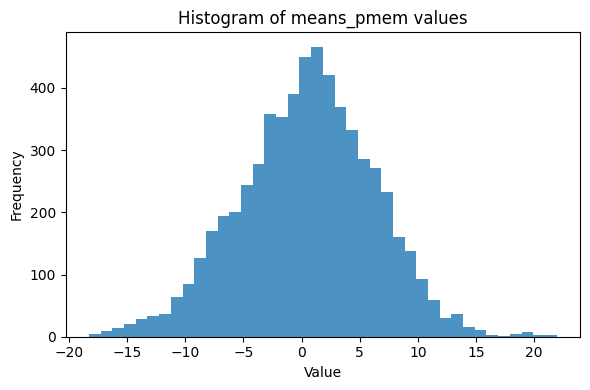

C:\Users\chris\AppData\Local\Temp\ipykernel_16620\1216082978.py:34: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  pmem_model = IsoHomGMMSharedParametersEstimator(


In [171]:
# ---- Build PMEM denoiser (uses training points as memorised means) ----
key, sk = random.split(key)

context = {
    "X_train": X_train,
    "init_var_scale": 1e-6,
    "init_means_noise_var": 0.0, # Not exactly sure what this is
}
means_pmem, var_pmem, priors_pmem = iso_hom_gmm_create_initialization_parameters(
    sk, IsoHomGMMInitStrategy.PMEM, laboratory_d, laboratory_M, context
)

print(f"Number of means in PMEM initialization: {len(means_pmem)}")
print(f"Number of priors in PMEM initialization: {len(priors_pmem)}")

# Print mean and var of all outputs from iso_hom_gmm_create_initialization_parameters
means_np = np.asarray(means_pmem)
var_np = np.asarray(var_pmem)
priors_np = np.asarray(priors_pmem)

print(f"means_pmem: mean={means_np.mean():.6f}, var={means_np.var():.6f}, shape={means_np.shape}")
print(f"var_pmem: mean={var_np.mean():.6f}, var={var_np.var():.6f}, shape={var_np.shape}")
print(f"priors_pmem: mean={priors_np.mean():.6f}, var={priors_np.var():.6f}, shape={priors_np.shape}")

plt.figure(figsize=(6,4))
plt.hist(means_np.ravel(), bins=40, alpha=0.8)
plt.title("Histogram of means_pmem values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Fix parameter order (use positional or correct keyword order)
pmem_model = IsoHomGMMSharedParametersEstimator(
    dim=laboratory_d,
    num_components=laboratory_M,
    vf_type=VectorFieldType.X0,
    diffusion_process=diffusion_process,
    init_means=means_pmem,
    init_var=var_pmem,
    priors=priors_pmem,
)


In [172]:
# Same for oracle
oracle_model = IsoHomGMMSharedParametersEstimator(
    dim=laboratory_d,
    num_components=laboratory_K,
    vf_type=VectorFieldType.X0,
    diffusion_process=diffusion_process,
    init_means=true_means,
    init_var=jnp.asarray(sample_variance),
    priors=equal_weighted_prior,
)

C:\Users\chris\AppData\Local\Temp\ipykernel_16620\4216398177.py:2: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  oracle_model = IsoHomGMMSharedParametersEstimator(


In [173]:
# ---- Evaluate losses ----
key, sk = random.split(key)
losses_pmem = evaluate_model_losses(sk, pmem_model, X_train, loss_obj, times)

key, sk = random.split(key)
losses_oracle = evaluate_model_losses(sk, oracle_model, X_train, loss_obj, times)

for tv, lp, lo in zip(times, losses_pmem, losses_oracle):
    print(f"t={float(tv):.3f}  PMEM={float(lp):.6e}  ORACLE={float(lo):.6e}  diff(PMEM-ORACLE)={float(lp-lo):.6e}")

print("Mean difference (PMEM - ORACLE):", float(jnp.mean(losses_pmem - losses_oracle)))

t=0.010  PMEM=2.948735e-07  ORACLE=3.002937e-03  diff(PMEM-ORACLE)=-3.002642e-03
t=0.049  PMEM=1.234877e-08  ORACLE=7.280489e-02  diff(PMEM-ORACLE)=-7.280488e-02
t=0.088  PMEM=3.814841e-09  ORACLE=2.345120e-01  diff(PMEM-ORACLE)=-2.345120e-01
t=0.128  PMEM=1.814698e-09  ORACLE=4.885869e-01  diff(PMEM-ORACLE)=-4.885869e-01
t=0.167  PMEM=1.050095e-09  ORACLE=8.353611e-01  diff(PMEM-ORACLE)=-8.353611e-01
t=0.206  PMEM=6.790473e-10  ORACLE=1.278009e+00  diff(PMEM-ORACLE)=-1.278009e+00
t=0.245  PMEM=4.704433e-10  ORACLE=1.805499e+00  diff(PMEM-ORACLE)=-1.805499e+00
t=0.284  PMEM=3.416964e-10  ORACLE=2.432496e+00  diff(PMEM-ORACLE)=-2.432496e+00
t=0.324  PMEM=2.572851e-10  ORACLE=3.134316e+00  diff(PMEM-ORACLE)=-3.134316e+00
t=0.363  PMEM=1.990058e-10  ORACLE=3.957177e+00  diff(PMEM-ORACLE)=-3.957177e+00
t=0.402  PMEM=1.563297e-10  ORACLE=4.857758e+00  diff(PMEM-ORACLE)=-4.857758e+00
t=0.441  PMEM=1.249421e-10  ORACLE=5.866807e+00  diff(PMEM-ORACLE)=-5.866807e+00
t=0.480  PMEM=1.004511e-10  

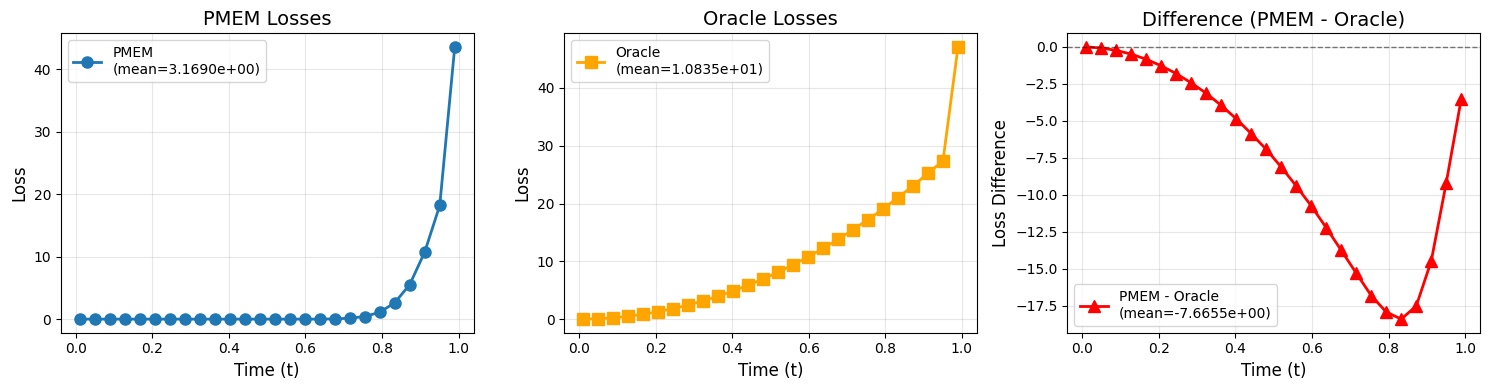

In [174]:
import matplotlib.pyplot as plt

# Calculate mean losses
mean_loss_pmem = float(jnp.mean(losses_pmem))
mean_loss_oracle = float(jnp.mean(losses_oracle))
mean_diff = float(jnp.mean(losses_pmem - losses_oracle))

# Plot the oracle losses individually, then the difference on a subplot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: PMEM losses
axes[0].plot(times, losses_pmem, 'o-', label=f'PMEM\n(mean={mean_loss_pmem:.4e})', linewidth=2, markersize=8)
axes[0].set_xlabel('Time (t)', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('PMEM Losses', fontsize=14)
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Plot 2: Oracle losses
axes[1].plot(times, losses_oracle, 's-', label=f'Oracle\n(mean={mean_loss_oracle:.4e})', linewidth=2, markersize=8, color='orange')
axes[1].set_xlabel('Time (t)', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Oracle Losses', fontsize=14)
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# Plot 3: Difference (PMEM - Oracle)
diff = losses_pmem - losses_oracle
axes[2].plot(times, diff, '^-', label=f'PMEM - Oracle\n(mean={mean_diff:.4e})', linewidth=2, markersize=8, color='red')
axes[2].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[2].set_xlabel('Time (t)', fontsize=12)
axes[2].set_ylabel('Loss Difference', fontsize=12)
axes[2].set_title('Difference (PMEM - Oracle)', fontsize=14)
axes[2].grid(True, alpha=0.3)
axes[2].legend()

plt.tight_layout()
plt.show()

In [175]:
# Calculate loss_L_N_t for both models
key, sk = random.split(key)
loss_L_N_t_pmem = calculate_L_N_t(sk, pmem_model, X_train, loss_obj, times)

key, sk = random.split(key)
loss_L_N_t_oracle = calculate_L_N_t(sk, oracle_model, X_train, loss_obj, times)

print(f"loss_L_N_t (PMEM): {float(loss_L_N_t_pmem):.6e}")
print(f"loss_L_N_t (Oracle): {float(loss_L_N_t_oracle):.6e}")
print(f"Difference (PMEM - Oracle): {float(loss_L_N_t_pmem - loss_L_N_t_oracle):.6e}")

loss_L_N_t (PMEM): 1.598758e-02
loss_L_N_t (Oracle): 5.457344e-02
Difference (PMEM - Oracle): -3.858586e-02
